# Clean & Explore the Data

After five notebooks worth of code, we finally have the press releases available to us. However, before I can start modeling, I first have to know when each press release was published so that I can determine whether it was before or after the start of the pandemic and assign it a label. Because each company's website is different, for some companies I extracted the dates from the website links (e.g., Apple, Walmart), while others I had to parse from the text of the press releases themselves (e.g., CVS, Exxon Mobil). Remember, we already have the year information for Amazon from when we were gathering the HTML from the newsroom.

Additionally, I created a `full_text` column, which is the combination of the `title` column and the `body` column. From the `full_text` column, I removed words that could leak the target variable (i.e., 2019, 2021, COVID, pandemic), as well as words I expected or found to have been unnecessary and removed for the sake of cleaning (e.g., company names, 'newsroom', 'menu', 'blog', 'press').

I also assigned the label in this notebook. For the purposes of this project, all press releases published before January 2020 are categorized as `before`, while all press releases published starting January 1, 2020 until present day are categorized as `after`. I chose January 2020 as the start date of the pandemic because, although lockdowns in the U.S. did not start until March, many companies were beginning to have supply chain issues as lockdowns in China caused significant manufacturing delays. 

Finally, I conduct some EDA on the final data at the end of this notebook.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import datetime as dt

import os

In [2]:
files = [f for f in os.listdir('../data/press_releases/') if 'csv' in f]
files

['apple_press_releases.csv',
 'cvs_health_press_releases.csv',
 'exxon_mobil_press_releases.csv',
 'walmart_press_releases.csv',
 'amazon_press_releases.csv']

## Finding the dates for each file and assigning the label

### Apple

For Apple, I extracted the year and month information from the link itself, converted this into the datetime format, and used that to get the year in the `year` column. I also added the `full_text` column, which is what the models will ultimately be trained on.

In [3]:
# find the dates
file = [f for f in files if 'apple' in f]
file
df = pd.read_csv(f'../data/press_releases/{file[0]}')

for row in range(len(df)):
    link_list = [i.strip() for i in df.loc[row,'full_link'].split('/') if i.strip() != '']
    df.loc[row,'date'] = '-'.join(link_list[3:5])

df['full_text'] = df['title'] + df['body']

df.date = df.date.map(lambda x: dt.datetime.strptime(x,'%Y-%m'))
df['year'] = df.date.map(lambda x: x.year)

df.head()

,full_link,title,body,html,date,full_text,year,label
0,https://www.apple.com/newsroom/2021/03/apple-e...,Apple earns historic Academy Award nominations...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Apple earns historic Academy Award nominations...,2021,after
1,https://www.apple.com/newsroom/2021/03/apple-w...,Apple Women’s Health Study releases preliminar...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Apple Women’s Health Study releases preliminar...,2021,after
2,https://www.apple.com/newsroom/2021/03/apple-t...,Apple TV+ announces programming partnership wi...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Apple TV+ announces programming partnership wi...,2021,after
3,https://www.apple.com/newsroom/2021/03/apple-h...,Apple Hearing Study shares new insights on hea...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Apple Hearing Study shares new insights on hea...,2021,after
4,https://www.apple.com/newsroom/2021/03/new-zea...,New Zealand students prototype their own Samoa...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,New Zealand students prototype their own Samoa...,2021,after


In [5]:
# assign the label

df['label'] = df.year.map(lambda x: 'after' if x >= 2020 else 'before')

In [6]:
# save it back

df.to_csv(f'../data/press_releases/{file[0]}', index = False)

### CVS Health

CVS was slightly more challenging to work with because the company does not put any publication date information into the link url for its press releases. In order to find the dates, I first split the text up and looked for patterns as to where in the text the company had the date, and then I used this information to create the function below that extracted the date from the press and converted it into a datetime object.

In [20]:
file = [f for f in files if 'cvs' in f]
df = pd.read_csv(f'../data/press_releases/{file[0]}')

years = [str(i) for i in range(2019,2022)]

for row in range(len(df)):
    para_list = [i.strip() for i in df.loc[row,'body'].split('\n') if i.strip() != '']
    df.loc[row,'date'] = '-'.join(para_list[3:6])
    
    for year in years:
        if (year in para_list[324]) & (len(para_list[324])<30):
            df.loc[row,'date'] = ','.join(para_list[324].split(',')[-2:]).strip()
            break
        
        elif (year in para_list[334]) & (len(para_list[334])<30):
            df.loc[row,'date'] = ','.join(para_list[334].split(',')[-2:]).strip()
            break
        
        else:
            df.loc[row,'date'] = None

df = df.dropna().reset_index(drop = True)

df['full_text'] = df.title + df.body

df.date = df.date.map(lambda x: dt.datetime.strptime(x,'%B %d, %Y'))
df['year'] = df.date.map(lambda x: x.year)

df.head()

,full_link,title,body,html,date,full_text,year
0,https://www.cvshealth.com/news-and-insights/pr...,CVS Health invests $114 million in affordable ...,\n\n\n\n\n\n\n\n Skip to main content\n...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2021-02-23,CVS Health invests $114 million in affordable ...,2021
1,https://www.cvshealth.com/news-and-insights/pr...,CVS Health now offering COVID-19 vaccines in 2...,\n\n\n\n\n\n\n\n Skip to main content\n...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2021-03-11,CVS Health now offering COVID-19 vaccines in 2...,2021
2,https://www.cvshealth.com/news-and-insights/pr...,CVS Health completes first round of COVID-19 v...,\n\n\n\n\n\n\n\n Skip to main content\n...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2021-01-25,CVS Health completes first round of COVID-19 v...,2021
3,https://www.cvshealth.com/news-and-insights/pr...,CVS Health launches Symphony™ to support senio...,\n\n\n\n\n\n\n\n Skip to main content\n...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2021-01-14,CVS Health launches Symphony™ to support senio...,2021
4,https://www.cvshealth.com/news-and-insights/pr...,"CVS Health names Kyu Rhee, M.D., MPP, as Senio...",\n\n\n\n\n\n\n\n Skip to main content\n...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2021-01-21,"CVS Health names Kyu Rhee, M.D., MPP, as Senio...",2021


In [21]:
# assign the label

df['label'] = df.year.map(lambda x: 'after' if x >= 2020 else 'before')

In [22]:
# save it back

df.to_csv(f'../data/press_releases/{file[0]}', index = False)

### Exxon Mobil

I followed a similar process for Exxon Mobil and found the date in the text of the press release and used this information to find the year and assign the label.

In [41]:
file = [f for f in files if 'exxon' in f]
df = pd.read_csv(f'../data/press_releases/{file[0]}')

for row in range(len(df)):

    para_list = [i.strip() for i in df.loc[row,'body'].split('\n') if i.strip() != '']

    for year in years:
        
        if (year in para_list[78]) & (len(para_list[78])<20):
            df.loc[row,'date'] = ','.join(para_list[78].split(',')[-2:]).strip()
            break
        
        elif (year in para_list[75]) & (len(para_list[75])<20):
            df.loc[row,'date'] = ','.join(para_list[75].split(',')[-2:]).strip()
            break
        
        else:
            df.loc[row,'date'] = None

            
df['full_text'] = df.title + df.body


months = {
    'Jan.':'January',
    'Feb.':'February',
    'Mar.':'March',
    'Apr.':'April',
    'Jun.':'June',
    'Jul.':'July',
    'Aug.':'August',
    'Sept.':'September',
    'Oct.':'October',
    'Nov.': 'November',
    'Dec.':'December'
}

for row in range(len(df)):
    for old,new in months.items():
        df.loc[row,'date']=df.loc[row,'date'].replace(old,new).replace('   •','')

        
df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x,'%B %d, %Y'))
df['year'] = df['date'].map(lambda x: x.year)

df.head()

,full_link,title,body,html,date,full_text,year
0,https://corporate.exxonmobil.com/News/Newsroom...,Darren Woods shares strategy for long term gro...,\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\...,"<!DOCTYPE html>\n<!--[if IE 9]><html lang=""en""...",2021-03-11,Darren Woods shares strategy for long term gro...,2021
1,https://corporate.exxonmobil.com/News/Newsroom...,ExxonMobil outlines plans to grow long-term sh...,\n\nSkip to content\n\n\n\nImportant Additiona...,"<!DOCTYPE html>\n<!--[if IE 9]><html lang=""en""...",2021-03-03,ExxonMobil outlines plans to grow long-term sh...,2021
2,https://corporate.exxonmobil.com/News/Newsroom...,ExxonMobil announces Singapore workforce reduc...,\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\...,"<!DOCTYPE html>\n<!--[if IE 9]><html lang=""en""...",2021-03-02,ExxonMobil announces Singapore workforce reduc...,2021
3,https://corporate.exxonmobil.com/News/Newsroom...,Neil Duffin to retire as president of ExxonMob...,\n\nSkip to content\n\n\n\nImportant Additiona...,"<!DOCTYPE html>\n<!--[if IE 9]><html lang=""en""...",2021-03-01,Neil Duffin to retire as president of ExxonMob...,2021
4,https://corporate.exxonmobil.com/News/Newsroom...,Michael Angelakis and Jeffrey Ubben join Exxon...,\n\nSkip to content\n\n\n\nImportant Additiona...,"<!DOCTYPE html>\n<!--[if IE 9]><html lang=""en""...",2021-03-01,Michael Angelakis and Jeffrey Ubben join Exxon...,2021


In [42]:
# assign the label

df['label'] = df.year.map(lambda x: 'after' if x >= 2020 else 'before')

In [43]:
# save it back

df.to_csv(f'../data/press_releases/{file[0]}', index = False)

### Walmart

For Walmart, similar to the process I used for Apple, I extracted the date from the link itself and turned that into a datetime object, which I then used to find the year and assign the label.

In [46]:
file = [f for f in files if 'walmart' in f]
df = pd.read_csv(f'../data/press_releases/{file[0]}')

for row in range(len(df)):
    para_list = [i.strip() for i in df.loc[row,'full_link'].split('/') if i.strip() != '']
    df.loc[row,'date'] = '-'.join(para_list[3:6])

df['full_text'] = df.title + df.body

df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
df['year'] = df['date'].map(lambda x: x.year)

df.head()

,full_link,title,body,html,date,full_text,year
0,https://corporate.walmart.com/newsroom/2021/03...,Walmart Investment to Accelerate Growth of Rak...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n© 2021 Wal...,"<!DOCTYPE html>\n<html class=""PressReleasePage...",2021-03-12,Walmart Investment to Accelerate Growth of Rak...,2021
1,https://corporate.walmart.com/newsroom/2021/03...,"Walmart Doubles Down on TikTok Shopping, Hosts...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n© 2021 Wal...,"<!DOCTYPE html>\n<html class=""PressReleasePage...",2021-03-09,"Walmart Doubles Down on TikTok Shopping, Hosts...",2021
2,https://corporate.walmart.com/newsroom/2021/03...,Walmart Board of Directors Adds Former AT&T Ch...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n© 2021 Wal...,"<!DOCTYPE html>\n<html class=""PressReleasePage...",2021-03-05,Walmart Board of Directors Adds Former AT&T Ch...,2021
3,https://corporate.walmart.com/newsroom/2021/03...,Walmart Maintains Relentless Focus on Growing ...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n© 2021 Wal...,"<!DOCTYPE html>\n<html class=""PressReleasePage...",2021-03-04,Walmart Maintains Relentless Focus on Growing ...,2021
4,https://corporate.walmart.com/newsroom/2021/03...,Walmart to Present at Bank of America 2021 Con...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n© 2021 Wal...,"<!DOCTYPE html>\n<html class=""PressReleasePage...",2021-03-04,Walmart to Present at Bank of America 2021 Con...,2021


In [47]:
# assign the label

df['label'] = df.year.map(lambda x: 'after' if x >= 2020 else 'before')

In [48]:
# save it back

df.to_csv(f'../data/press_releases/{file[0]}', index = False)

### Amazon

Because of how Amazon structures its news room, I was able to bring the year with me and simply used that to assign the label. I also added the full text column. 

In [60]:
file = [f for f in files if 'amazon' in f]
df = pd.read_csv(f'../data/press_releases/{file[0]}')

df['full_text'] = df['title'] + df['body']

df.head()

,full_link,title,body,html,year,label,full_text
0,https://press.aboutamazon.com/news-releases/ne...,Amazon Continues Investment in Florida with De...,\n\n\n\n\n\n\n\n Skip to main navigatio...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2019,before,Amazon Continues Investment in Florida with De...
1,https://press.aboutamazon.com/news-releases/ne...,Customers Shopped at Record Levels this Holida...,\n\n\n\n\n\n\n\n Skip to main navigatio...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2019,before,Customers Shopped at Record Levels this Holida...
2,https://press.aboutamazon.com/news-releases/ne...,Amazon Has Enabled Hundreds of Small Businesse...,\n\n\n\n\n\n\n\n Skip to main navigatio...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2019,before,Amazon Has Enabled Hundreds of Small Businesse...
3,https://press.aboutamazon.com/news-releases/ne...,Amazon Makes Returns Even Easier This Holiday ...,\n\n\n\n\n\n\n\n Skip to main navigatio...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2019,before,Amazon Makes Returns Even Easier This Holiday ...
4,https://press.aboutamazon.com/news-releases/ne...,Amazon Helps Keep the Holidays ‘Spoiler Free’ ...,\n\n\n\n\n\n\n\n Skip to main navigatio...,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""en"" pre...",2019,before,Amazon Helps Keep the Holidays ‘Spoiler Free’ ...


In [52]:
# assign the label

df['label'] = df.year.map(lambda x: 'after' if x >= 2020 else 'before')

In [61]:
# save it back

df.to_csv(f'../data/press_releases/{file[0]}', index = False)

## Removing potential leak words

Although the target variables are `before` and `after`, other potential words are likely to be highly correlated with the target, such as the year (i.e., 2019, 2020, 2021) and words related to the pandemic (e.g., pandemic, coronavirus, COVID). Additionally, the companies' names are mostly filler but are likely to be in the text often, as are words related to the website. 

In the cell below, I've created a loop that first goes through every file, and then for each word in the `leak_words` list, removes that word from the full text of the DataFrame and saves it back before moving on to the next word. 

In [62]:
leak_words = [
    '2021', '2020', '2019', 'Covid-19', 'Covid', 'COVID-19', 'COVID',
    'Coronavirus', 'coronavirus', 'pandemic', 'Amazon', 'Apple', 'Walmart', 
    'CVS Health', 'CVS', 'Exxon Mobil', 'Exxon', 'menu','newsroom',
    'amazon.com', 'blog', 'press', '\n', '\r', '\t'
]

for file in tqdm(files):
    df = pd.read_csv(f'../data/press_releases/{file}')
    
    for word in leak_words:
        df.full_text = df.full_text.map(lambda x: x.replace(word,''))
    
    df.to_csv(f'../data/press_releases/{file}', index = False)

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


## EDA

In [7]:
files = [f for f in os.listdir('../data/press_releases/') if 'csv' in f]

full = pd.DataFrame()

for file in files:
    new = pd.read_csv(f'../data/press_releases/{file}')
    full = pd.concat([full,new],ignore_index=True)

full.head(3)

,full_link,title,body,html,date,full_text,year,label
0,https://www.apple.com/newsroom/2021/03/apple-e...,Apple earns historic Academy Award nominations...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,earns historic Academy Award nominations for ...,2021,after
1,https://www.apple.com/newsroom/2021/03/apple-w...,Apple Women’s Health Study releases preliminar...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Women’s Health Study releases preliminary dat...,2021,after
2,https://www.apple.com/newsroom/2021/03/apple-t...,Apple TV+ announces programming partnership wi...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,TV+ announces programming partnership with No...,2021,after


In [20]:
eda = pd.DataFrame()

for row in range(len(full)):
    if 'www.apple.com' in full.loc[row, 'full_link']:
        eda.loc[row, 'company'] = 'Apple'
    elif 'www.cvshealth.com' in full.loc[row, 'full_link']:
        eda.loc[row, 'company'] = 'CVS Health'
    elif 'exxonmobil.com' in full.loc[row, 'full_link']:
        eda.loc[row, 'company'] = 'Exxon Mobil'
    elif 'walmart.com' in full.loc[row, 'full_link']:
        eda.loc[row, 'company'] = 'Walmart'
    elif 'press.aboutamazon.com' in full.loc[row, 'full_link']:
        eda.loc[row, 'company'] = 'Amazon'
        
eda['full_text_char_lengths'] = full.full_text.map(lambda x: len(x))
eda['labels'] = full.label

In [25]:
# eda.groupby(by='company').mean()
eda.groupby(by=['company','labels']).count()

full_text_char_lengths
company     labels                        
Amazon      after                      234
            before                     215
Apple       after                      127
            before                     136
CVS Health  after                      171
            before                     123
Exxon Mobil after                       73
            before                      70
Walmart     after                      250
            before                     187

''

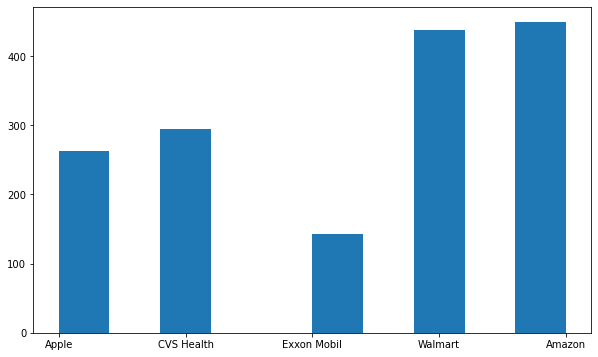

In [27]:
plt.figure(figsize=(10,6))
plt.hist(eda.company)
;

In [43]:
eda[eda.labels=='before']

company                   731
full_text_char_lengths    731
labels                    731
dtype: int64

<BarContainer object of 5 artists>

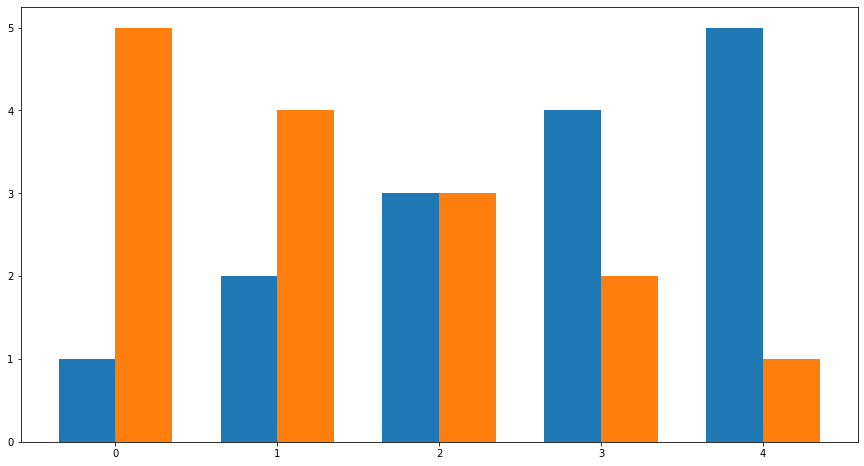

In [40]:
xlabels = np.arange(5)
width = .35

fig, ax = plt.subplots(figsize=(15,8))



ax.bar(xlabels-width/2, [1,2,3,4,5], width, label='Before')
ax.bar(xlabels+width/2, [5,4,3,2,1], width, label='After')